# Plot real-time met and fluxes from WGs in IOP2

This is pretty good, but there is room for improvement:
1. Getting to here currently involves multiple steps that are notebooks (WG_realtime_cleanup.ipynb, this file);  it would be nicer if those were python sctipts I could run with less interaction
2. Calling COARE3.6 works fine, but I could write a wrapper function that would return the results in a more convenient format (e.g., return all variables and write to netCDF).  In other words, I should definitely make a standardized output, with metadata.
3. Make it automatically account for measurement height? (I don't think the info is in realtime NetCDF files.)
4. Currently not accounting for water velocity
5. I was also a little sloppy in dealing with things like time in the input to COARE-- I don't know if that matters, but maybe it does; this is something I could fix in a "wrapper"

### Notes for creating a "wrapper"
- I could copy the way Ben wrote to NetCDF in read_NAVO_write_netcdf.py
- Or, I could try using xarray.to_netcdf()

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cftime
import requests
import cartopy.crs as ccrs                   # import projections
import cartopy
import gsw
import functions  # requires functions.py from this directory
from scipy.stats import binned_statistic_2d

# For running COARE
import sys
sys.path.insert(0,'../../COARE-algorithm/Python/COARE3.6/')
from coare36vn_zrf_et import coare36vn_zrf_et


In [2]:
plt.close('all')

In [3]:
%matplotlib inline
%matplotlib widget
# %matplotlib qt5
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

__figdir__ = '../plots/vel_fits/' 
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

In [4]:
savefig = True


In [5]:
# List of WGs
WG_list = ['WHOI22','WHOI32','WHOI43','STOKES', 'PLANCK', 'KELVIN', 'CARSON','WHOI1102']
path='../data/raw/WG_NRT_IOP2/'

In [6]:
# Make a list of the files:
n=0
file_list = []
for WG in WG_list:
    file = path+'met_'+WG+'.nc'
    file_list.append(file)

In [7]:
file_list

['../data/raw/WG_NRT_IOP2/met_WHOI22.nc',
 '../data/raw/WG_NRT_IOP2/met_WHOI32.nc',
 '../data/raw/WG_NRT_IOP2/met_WHOI43.nc',
 '../data/raw/WG_NRT_IOP2/met_STOKES.nc',
 '../data/raw/WG_NRT_IOP2/met_PLANCK.nc',
 '../data/raw/WG_NRT_IOP2/met_KELVIN.nc',
 '../data/raw/WG_NRT_IOP2/met_CARSON.nc',
 '../data/raw/WG_NRT_IOP2/met_WHOI1102.nc']

In [8]:
# Read in cleaned met files from all WG
n=0
for WG in WG_list:
    file = file_list[n]
    varstr = 'met_'+WG
    locals()[varstr]=xr.open_dataset(file,decode_times=True) #Time and z already fixed in WG_realtime_cleanup.ipynb
    n=n+1
    print(file)

../data/raw/WG_NRT_IOP2/met_WHOI22.nc
../data/raw/WG_NRT_IOP2/met_WHOI32.nc
../data/raw/WG_NRT_IOP2/met_WHOI43.nc
../data/raw/WG_NRT_IOP2/met_STOKES.nc
../data/raw/WG_NRT_IOP2/met_PLANCK.nc
../data/raw/WG_NRT_IOP2/met_KELVIN.nc
../data/raw/WG_NRT_IOP2/met_CARSON.nc
../data/raw/WG_NRT_IOP2/met_WHOI1102.nc


In [9]:
#Compute density from T and cond
p = 1
for WG in WG_list:
    ds = eval('met_'+WG)
    ds['uctd_psu_Avg']=gsw.conversions.SP_from_C(10*ds.uctd_cond_Avg, ds.uctd_temp_Avg, p)
    SA = gsw.conversions.SA_from_SP(ds.uctd_psu_Avg, 1,ds.longitude_1hz_Avg, ds.latitude_1hz_Avg)
    CT = gsw.conversions.CT_from_t(SA, ds.uctd_temp_Avg, p)
    ds['uctd_sigma0_Avg'] = gsw.density.sigma0(SA, CT)
    varstr = 'met_'+WG
    locals()[varstr]= ds

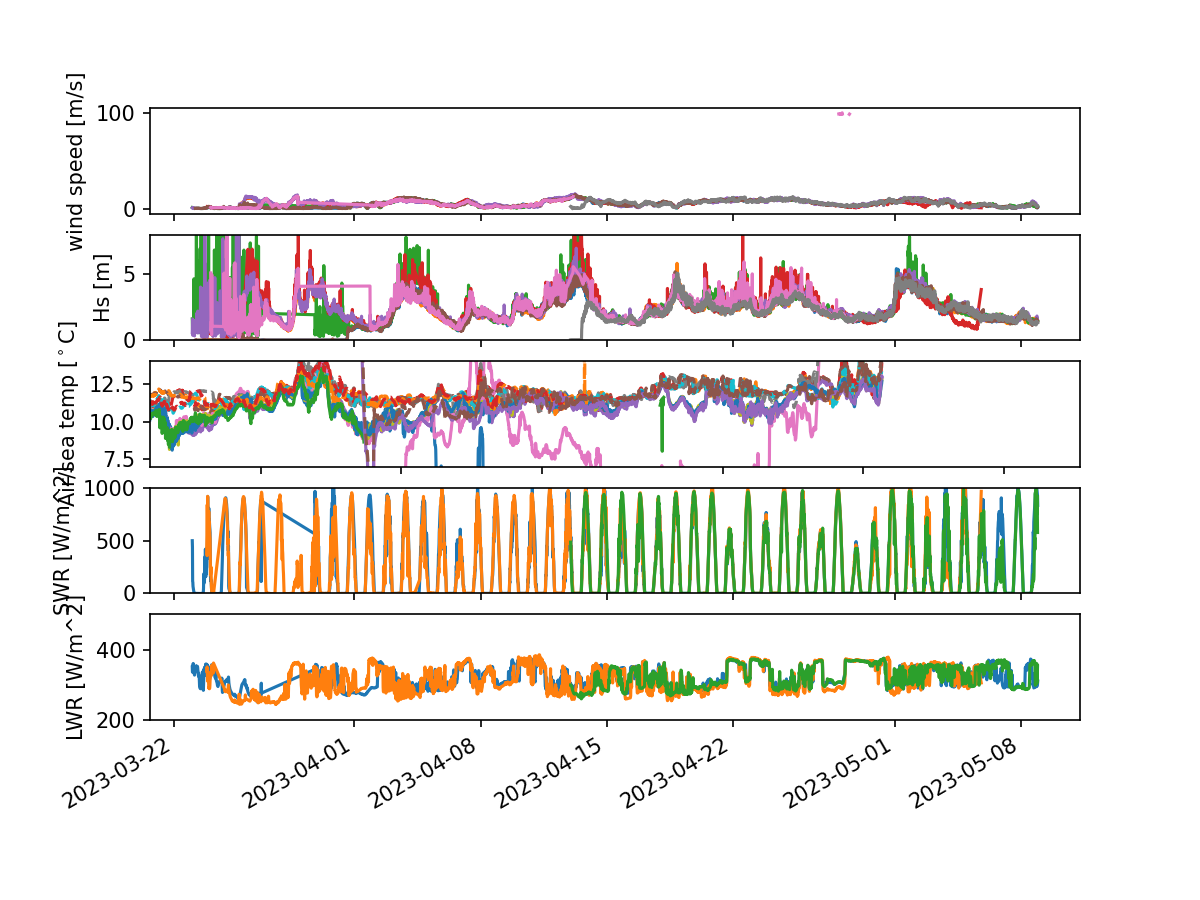

In [10]:
tmin = np.datetime64('2023-04-02T12:00:00')
tmax = np.datetime64('now')

fig, ax = plt.subplots(5,1,figsize=(8, 6))
for WG in WG_list:
    ds = eval('met_'+WG)
    ax[0].plot(ds.time,ds.TrueWindSpeed_Avg)
    ax[0].set(ylabel='wind speed [m/s]')
    try:
        ax[1].plot(ds.time,ds.Hs_std)
    except:
         ax[1].plot(ds.time,ds.Hs_1hz_std)       
    ax[1].set(ylabel='Hs [m]')
    ax[1].set_ylim(bottom=0, top=8)

    ax[2].plot(ds.time,ds.atmospheric_temperature_Avg)
    ax[2].plot(ds.time,ds.uctd_temp_Avg,'--')    
    ax[2].set(ylabel='Air/sea temp [$^\circ$C]')
    ax[2].set_ylim(bottom=7, top=14)

    try:
        ax[3].plot(ds.time,ds.SR03_SW_flux_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    try:
        ax[3].plot(ds.time,ds.SMP21_flux_Wm2_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    
    ax[3].set(ylabel='SWR [W/m^2]')
    ax[3].set_ylim(bottom=0, top=1000)
 
    try:
        ax[4].plot(ds.time,ds.IR02_LW_flux_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    try:
        ax[4].plot(ds.time,ds.SGR4_flux_Wm2_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    
    ax[4].set(ylabel='LWR [W/m^2]')
    ax[4].set_ylim(bottom=200, top=500)

fig.autofmt_xdate()
ax[2].set_xlim(left=tmin, right=tmax)
plt.show()



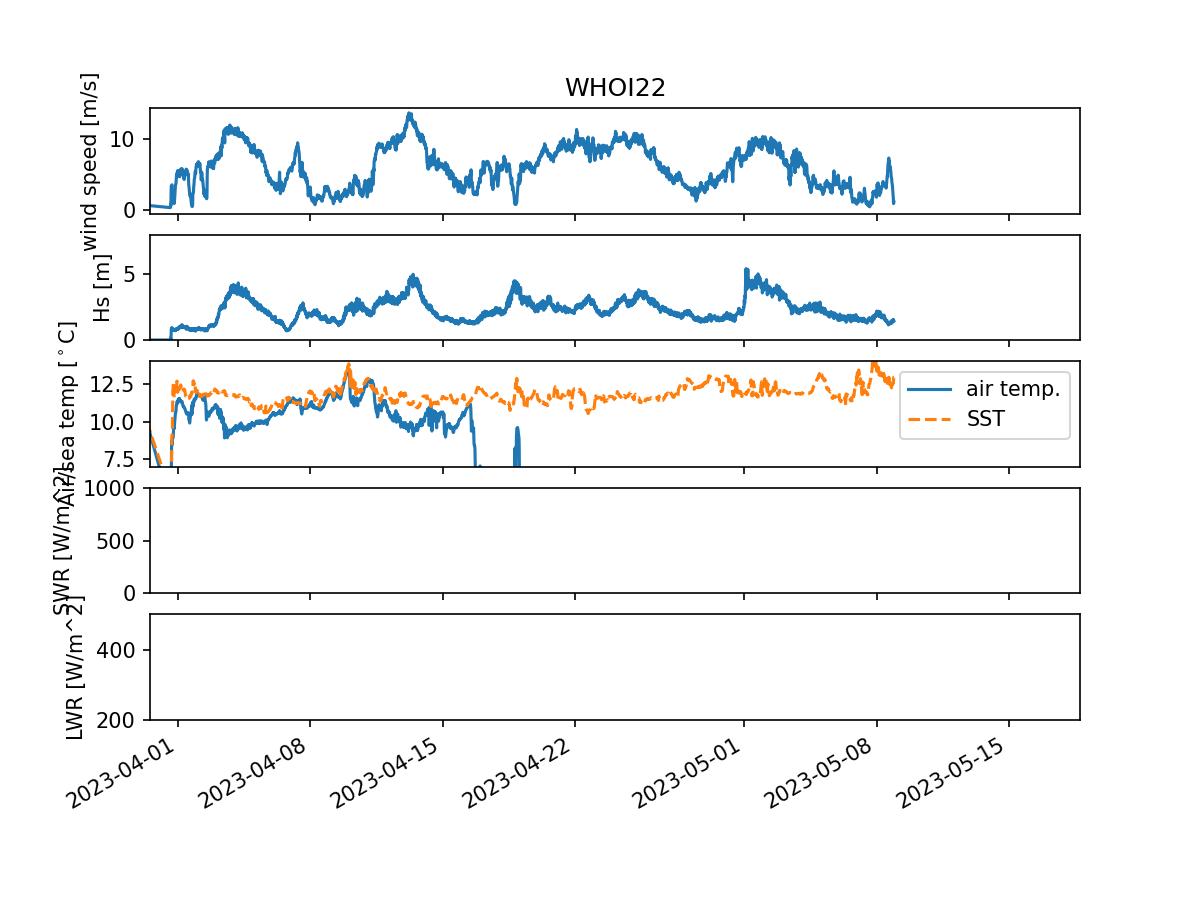

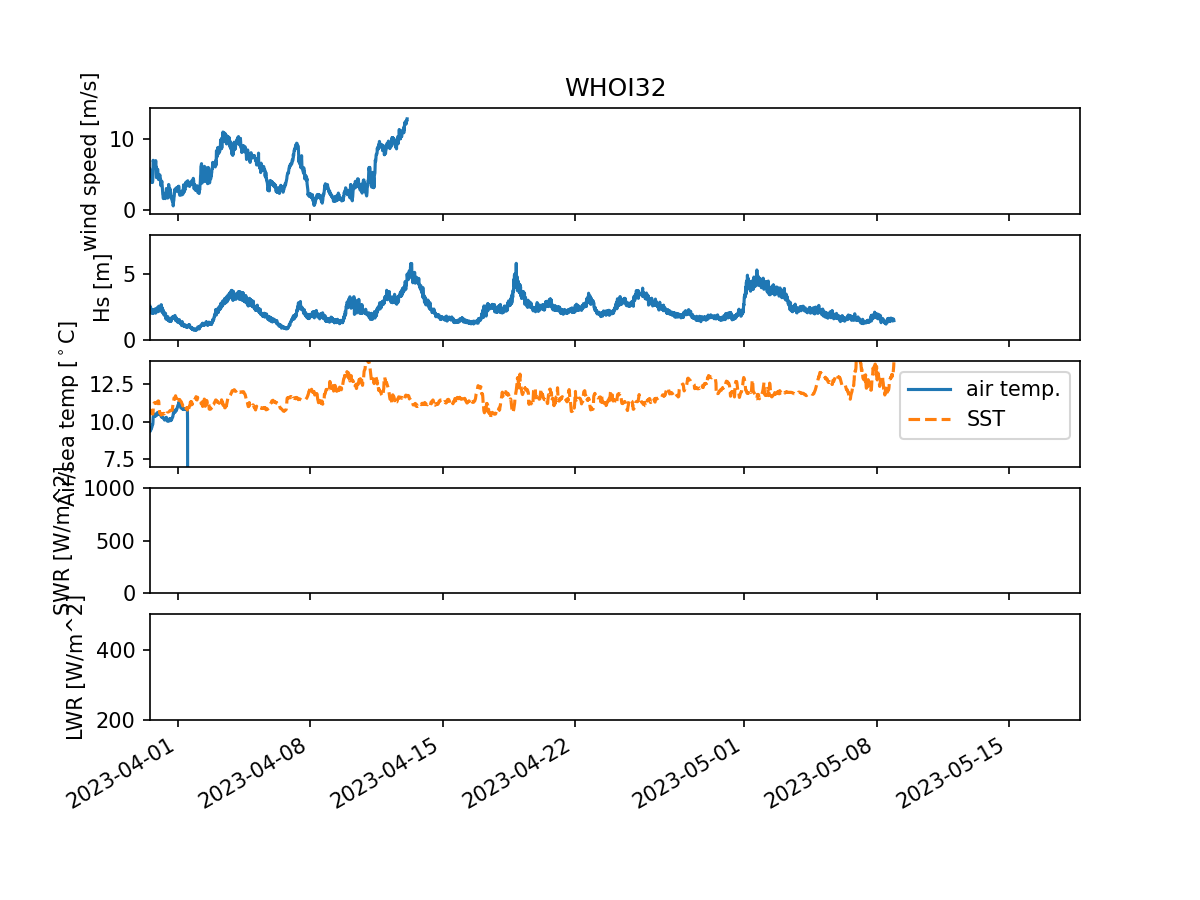

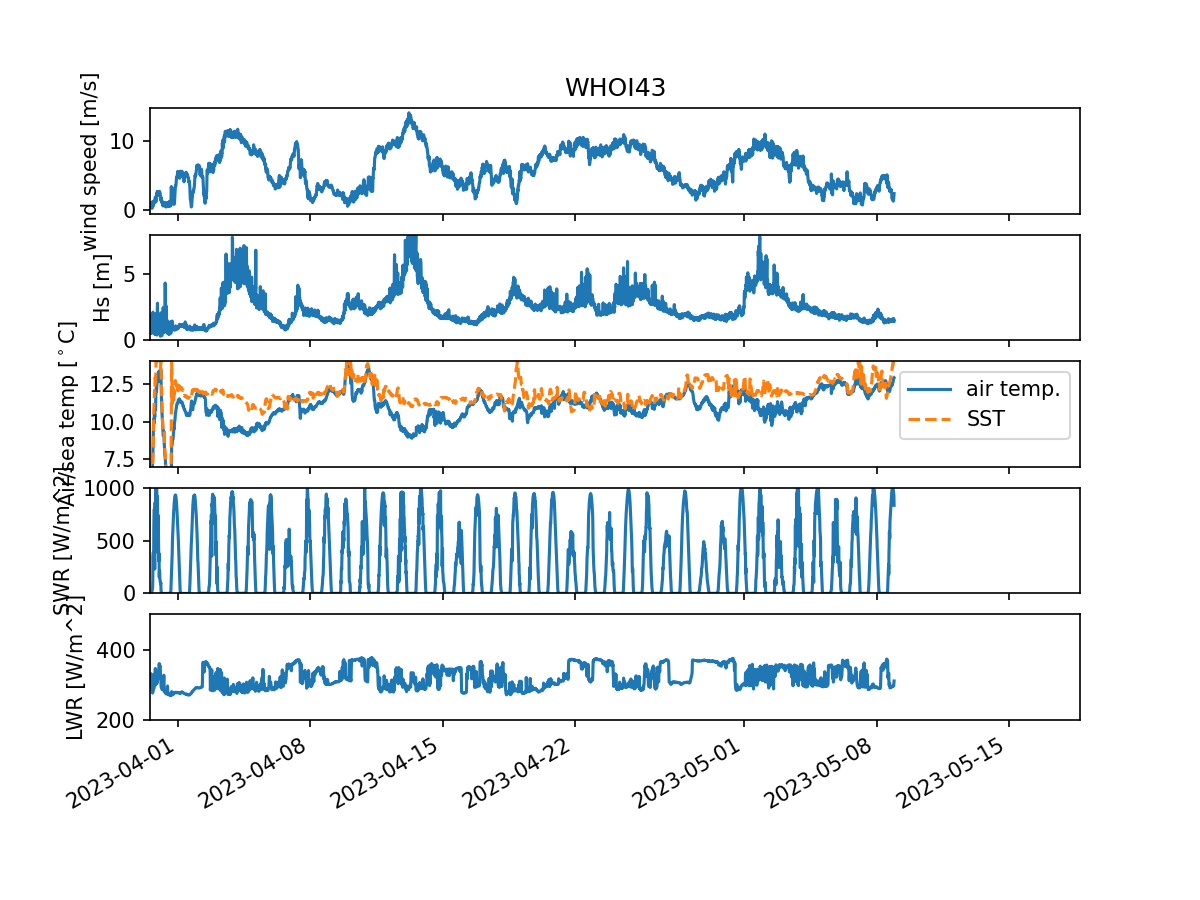

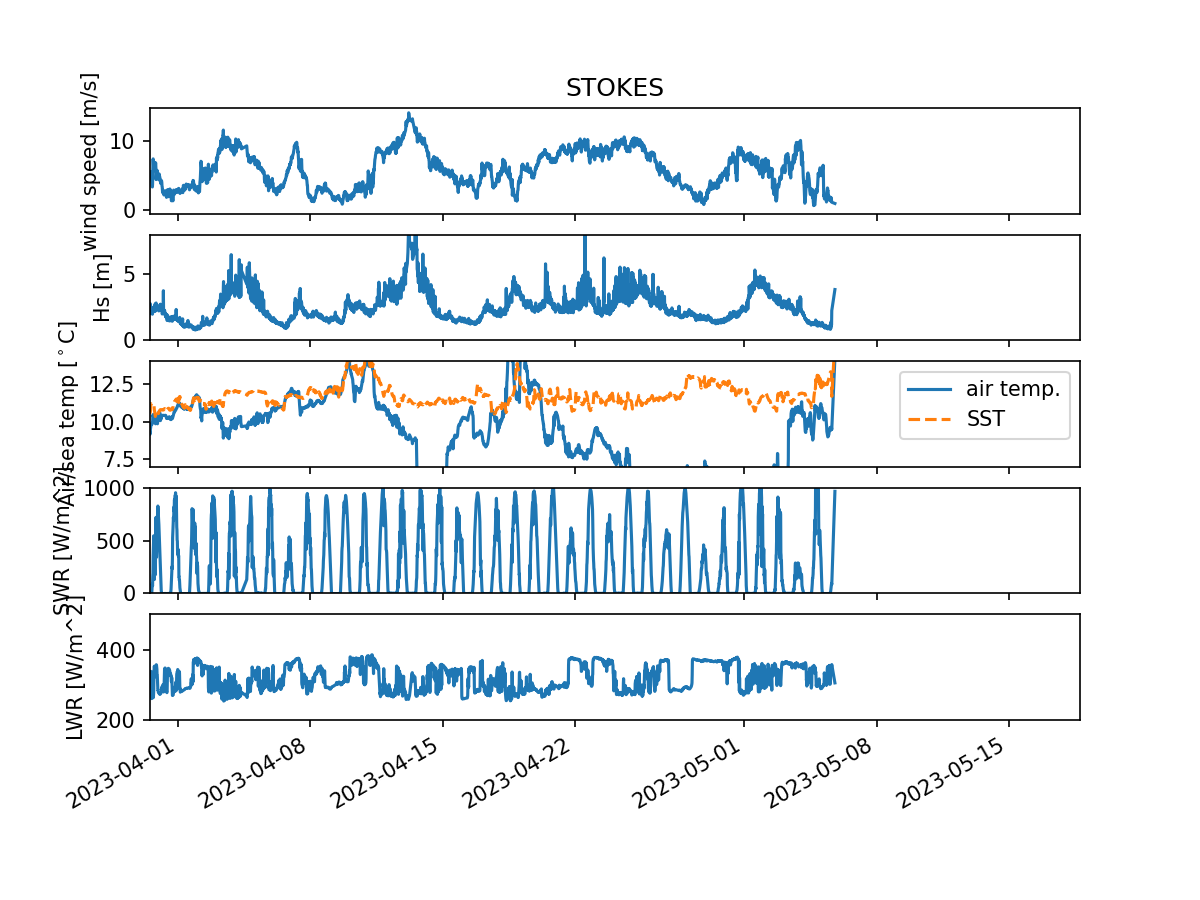

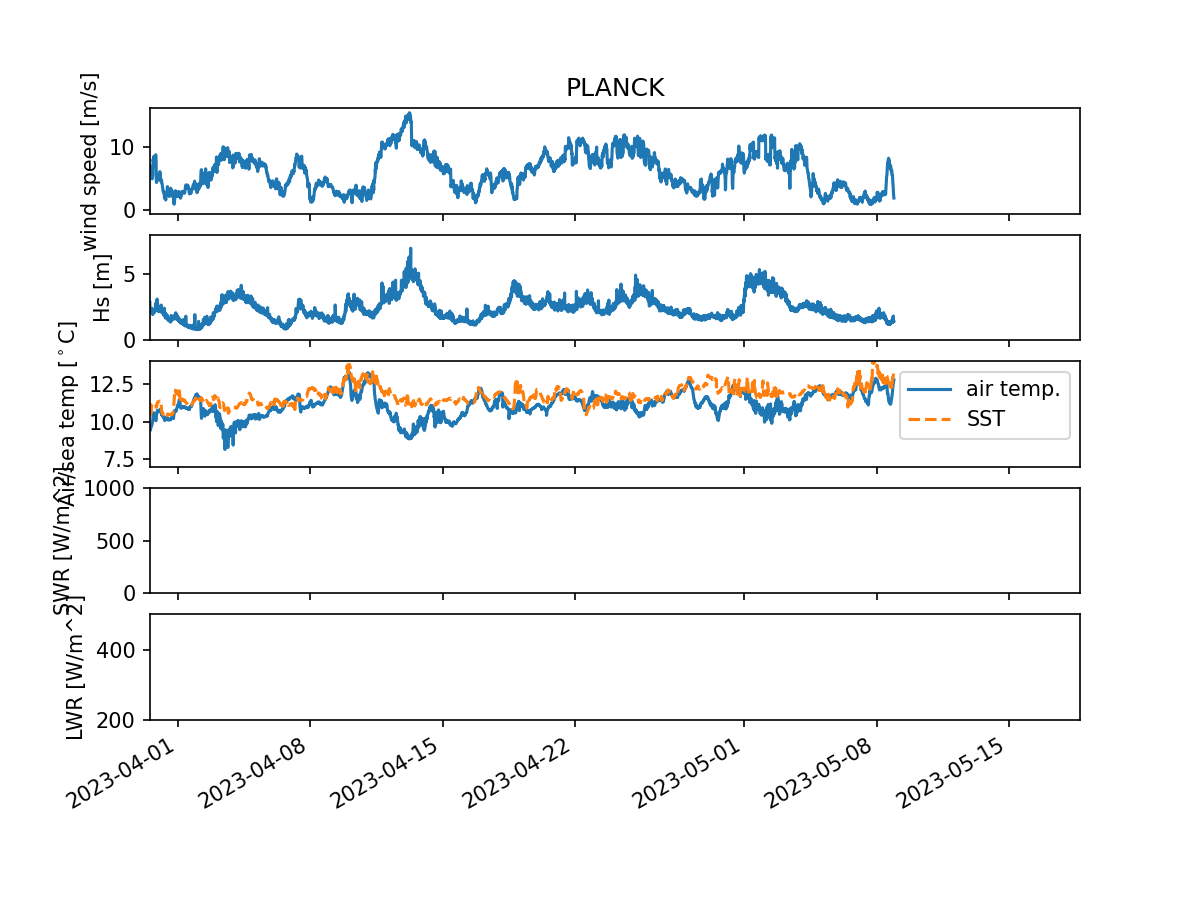

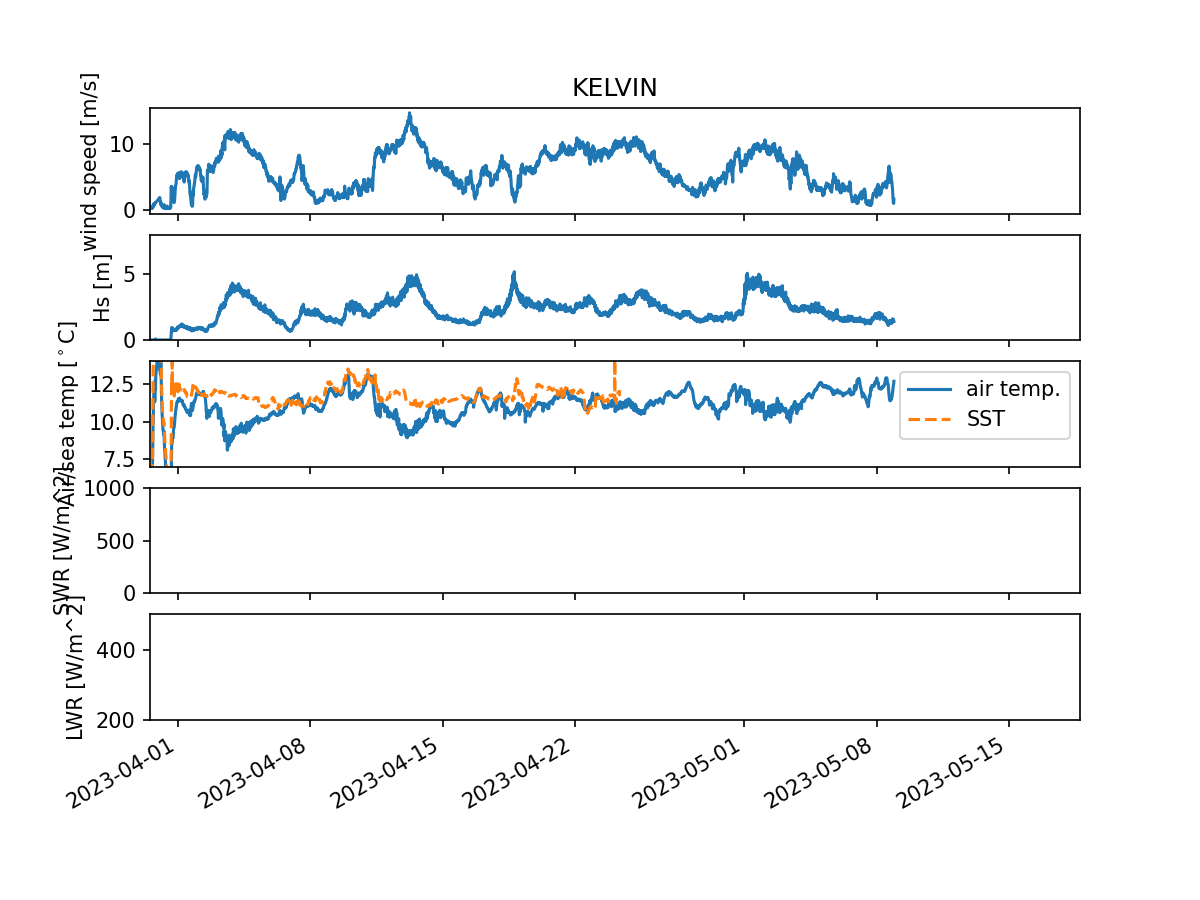

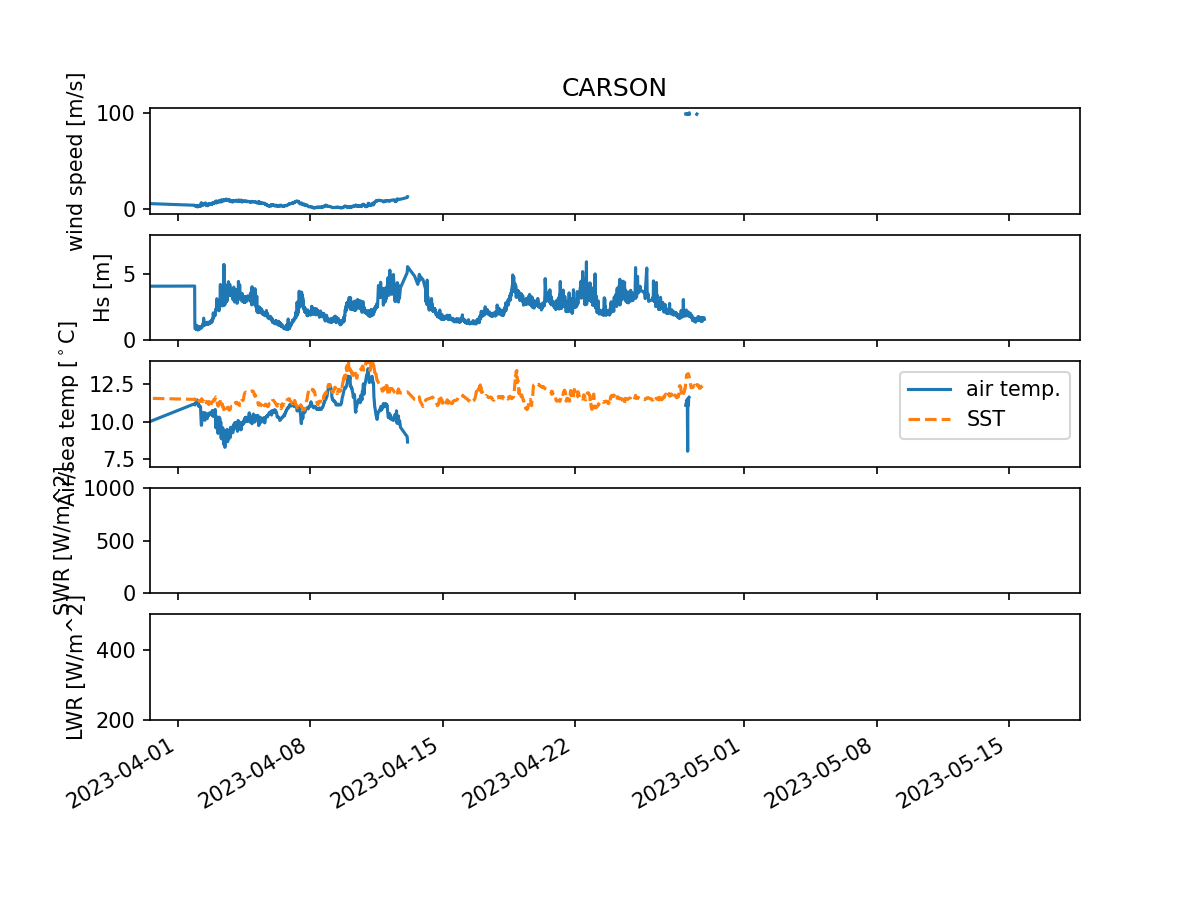

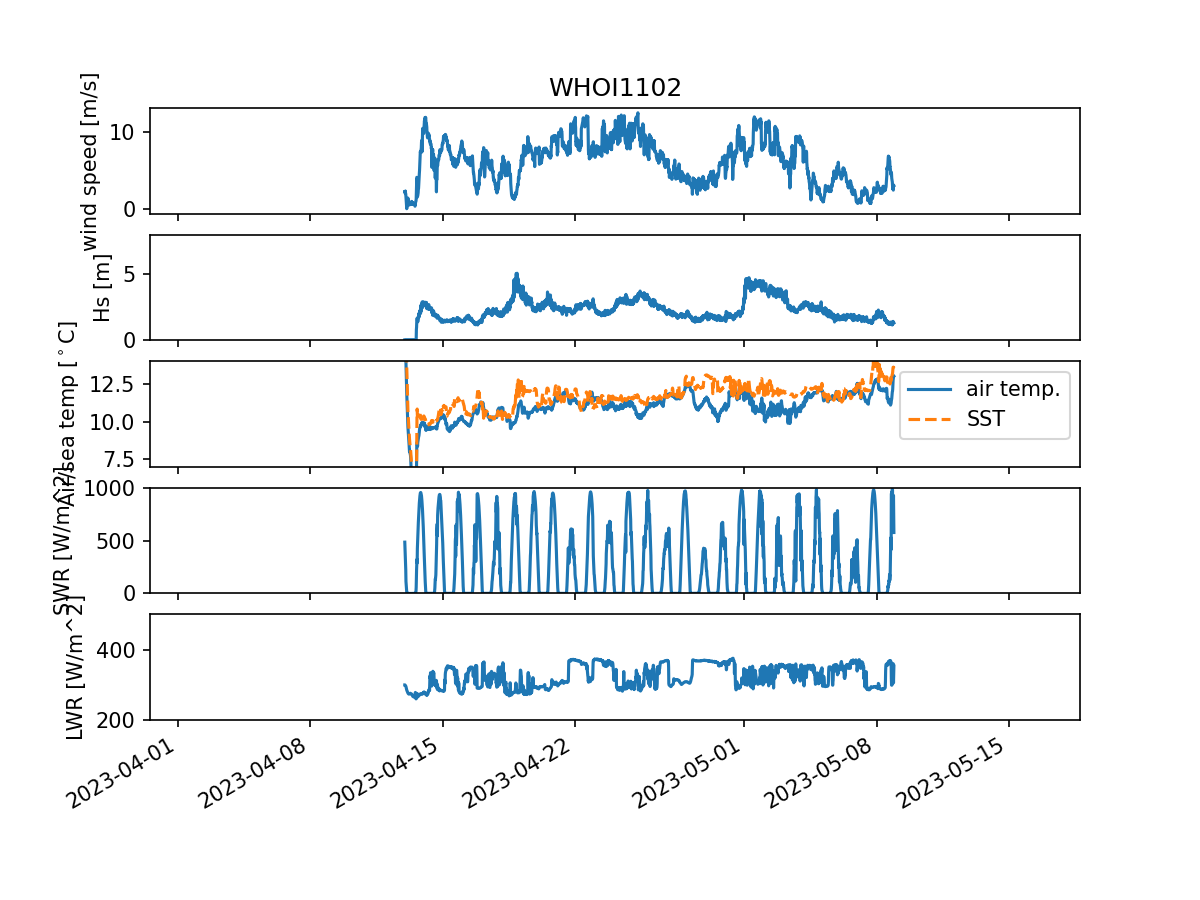

In [11]:
tmin = np.datetime64('2023-03-30T12:00:00')
tmax = np.datetime64('now')

# Make one plot for each WG
for WG in WG_list:
    ds = eval('met_'+WG)
    fig, ax = plt.subplots(5,1,figsize=(8, 6),sharex=True)
    ax[0].plot(ds.time,ds.TrueWindSpeed_Avg)
    ax[0].set(ylabel='wind speed [m/s]')
    ax[0].set_xlim(left=tmin, right=tmax)
    ax[0].set_title(WG)
    try:
        ax[1].plot(ds.time,ds.Hs_std)
    except:
         ax[1].plot(ds.time,ds.Hs_1hz_std)       
    ax[1].set(ylabel='Hs [m]')
    ax[1].set_ylim(bottom=0, top=8)

    ax[2].plot(ds.time,ds.atmospheric_temperature_Avg)
    ax[2].plot(ds.time,ds.uctd_temp_Avg,'--')    
    ax[2].set(ylabel='Air/sea temp [$^\circ$C]')
    ax[2].set_ylim(bottom=7, top=14)
    ax[2].legend(['air temp.','SST'])

    try:
        ax[3].plot(ds.time,ds.SR03_SW_flux_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    try:
        ax[3].plot(ds.time,ds.SMP21_flux_Wm2_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    
    ax[3].set(ylabel='SWR [W/m^2]')
    ax[3].set_ylim(bottom=0, top=1000)
 
    try:
        ax[4].plot(ds.time,ds.IR02_LW_flux_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    try:
        ax[4].plot(ds.time,ds.SGR4_flux_Wm2_Avg)
    except:
        #ax[1].plot(ds.time,ds.Hs_1hz_std)   
        pass
    
    ax[4].set(ylabel='LWR [W/m^2]')
    ax[4].set_ylim(bottom=200, top=500)

    fig.autofmt_xdate()
   
    ax[2].set_xlim(left=tmin, right=tmax)
    plt.show()


In [12]:
ds = met_WHOI43

In [13]:
ds

<xarray.Dataset>
Dimensions:                      (time: 4131)
Coordinates:
  * time                         (time) datetime64[ns] 2023-03-23T00:01:00 .....
Data variables: (12/46)
    cr6_card_status              (time) object ...
    batt_volt_Min                (time) float64 ...
    panel_temp_Avg               (time) float64 ...
    proc_time_Max                (time) float64 ...
    proc_time_Avg                (time) float64 ...
    slow_proc_time_1_Max         (time) float64 ...
    ...                           ...
    SGR4_flux_Wm2_Avg            (time) float64 350.8 336.1 ... 303.4 310.9
    index_1hz_file               (time) float64 ...
    index_10hz_file              (time) float64 ...
    index_ADCP_file              (time) float64 ...
    uctd_psu_Avg                 (time) float64 0.004334 0.004352 ... 33.05
    uctd_sigma0_Avg              (time) float64 -0.9844 -0.964 ... 24.66 24.67
Attributes:
    title:                S-MODE IOP2 2023 wave glider
    summary:              real-time wave glider data recorded by SV3 during S...
    time_coverage_start:  2023-03-23T00:16:00Z
    time_coverage_end:    2023-05-08T22:16:00Z

In [14]:
 #  u = water-relative wind speed magnitude (m/s) at height zu (m)
#             i.e. mean wind speed accounting for the ocean current vector.
#             i.e. the magnitude of the difference between the wind vector
#             (at height zu) and ocean surface current vector.
#             If not available, use true wind speed to compute fluxes in
#             earth-coordinates only which will be ignoring the stress
#             contribution from the ocean current to all fluxes
#  t = air temperature (degC) at height zt (m)
#  rh = relative humidity (#) at height zq (m)
#  P = sea level air pressure (mb)
#  ts = seawater temperature (degC), see jcool below for cool skin
#             calculation, and separate warm layer code for specifying
#             sensor depth and whether warm layer is computed
#  sw_dn = downward (positive) shortwave radiation (W/m^2)
#  lw_dn = downward (positive) longwave radiation (W/m^2)
#  lat = latitude defined positive to north
#  lon = longitude defined positive to east, if using other version,
#             adjust the eorw string input to albedo_vector function
#  jd = year day or julian day, where day Jan 1 00:00 UTC = 0
#  zi = PBL height (m) (default or typical value = 600m)
#  rain = rain rate (mm/hr)
#  Ss = sea surface salinity (PSU)
#  cp = phase speed of dominant waves (m/s) computed from peak period
#  sigH = significant wave height (m)
#  zu, zt, zq heights of the observations (m)
#  zrf_u, zrf_t, zrf_q  reference height for profile.  Use this to compare observations at different heights

u = ds.TrueWindSpeed_Avg.values
t = ds.atmospheric_temperature_Avg.values
rh = ds.relative_humidity_Avg.values
P = ds.atmospheric_pressure_Avg.values
ts =  ds.uctd_temp_Avg.values
try:
    sw_dn = ds.SR03_SW_flux_Avg.values
except:  
    pass
try:
    sw_dn = ds.SMP21_flux_Wm2_Avg.values
except:
    pass

try:
    lw_dn = ds.IR02_LW_flux_Avg.values
except:
    pass
try:
    lw_dn = ds.SGR4_flux_Wm2_Avg.values
except:
    pass

lat = ds.latitude_1hz_Avg.values
lon = ds.longitude_1hz_Avg.values
jd = 120 # ds.time
zi = 600
rain = 0
Ss = 33
try:
    sigH = ds.Hs_std.values
except:
     sigH = ds.Hs_1hz_std.values
cp = np.nan
zu = 1 # heights of the observations (m)
zt = 1
zq = 1
zrf_u = 10 #reference height for profile.  Use this to compare observations at different heights
zrf_t = 10 #reference height for profile.  Use this to compare observations at different heights
zrf_q = 10 #reference height for profile.  Use this to compare observations at different heights


In [15]:
A = coare36vn_zrf_et(u, zu , t, zt, rh, zq, P, ts, sw_dn, lw_dn, lat, lon,jd, zi,rain, Ss, cp=None, sigH=None, zrf_u=10.0, zrf_t=10.0, zrf_q=10.0)

/home/jtomf/Python/S-MODE_analysis/code_IOP2/../../COARE-algorithm/Python/COARE3.6/coare36vn_zrf_et.py:750: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/home/jtomf/Python/S-MODE_analysis/code_IOP2/../../COARE-algorithm/Python/COARE3.6/coare36vn_zrf_et.py:715: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43


In [16]:
#0    usr = friction velocity that includes gustiness (m/s), u*
#1   tau = wind stress that includes gustiness (N/m^2)
#2    hsb = sensible heat flux (W/m^2) ... positive for Tair < Tskin
#3    hlb = latent heat flux (W/m^2) ... positive for qair < qs
#4    hbb = atmospheric buoyany flux (W/m^2)... positive when hlb and hsb heat the atmosphere
#5    hsbb = atmospheric buoyancy flux from sonic ... as above, computed with sonic anemometer T
#6    hlwebb = webb factor to be added to hl covariance and ID latent heat fluxes
#7    tsr = temperature scaling parameter (K), t*
#8    qsr = specific humidity scaling parameter (kg/kg), q*
#9    zo = momentum roughness length (m)
#10   zot = thermal roughness length (m)
#11   zoq = moisture roughness length (m)
#12   Cd = wind stress transfer (drag) coefficient at height zu (unitless)
#13    Ch = sensible heat transfer coefficient (Stanton number) at height zu (unitless)
#14    Ce = latent heat transfer coefficient (Dalton number) at height zu (unitless)
#15    L = Monin-Obukhov length scale (m)
#16    zeta = Monin-Obukhov stability parameter zu/L (dimensionless)
#17    dT_skin = cool-skin temperature depression (degC), pos value means skin is cooler than subskin
#18    dq_skin = cool-skin humidity depression (g/kg)
#19    dz_skin = cool-skin thickness (m)
#20    Urf = wind speed at reference height (user can select height at input)
#21    Trf = air temperature at reference height
#22    Qrf = air specific humidity at reference height
#23    RHrf = air relative humidity at reference height
#24    UrfN = neutral value of wind speed at reference height
#25    TrfN = neutral value of air temp at reference height
#26    qarfN = neutral value of air specific humidity at reference height
#27    lw_net = Net IR radiation computed by COARE (W/m2)... positive heating ocean
#28    sw_net = Net solar radiation computed by COARE (W/m2)... positive heating ocean
#29    Le = latent heat of vaporization (J/K)
#30    rhoa = density of air at input parameter height zt, typically same as zq (kg/m3)
#31    UN = neutral value of wind speed at zu (m/s)
#32    U10 = wind speed adjusted to 10 m (m/s)
#33    UN10 = neutral value of wind speed at 10m (m/s)
#    Cdn_10 = neutral value of drag coefficient at 10m (unitless)
#    Chn_10 = neutral value of Stanton number at 10m (unitless)
#    Cen_10 = neutral value of Dalton number at 10m (unitless)
#    hrain = rain heat flux (W/m^2)... positive cooling ocean
#    Qs = sea surface specific humidity, i.e. assuming saturation (g/kg)
#    Evap = evaporation rate (mm/h)
#    T10 = air temperature at 10m (deg C)
#    Q10 = air specific humidity at 10m (g/kg)
#    RH10 = air relative humidity at 10m (#)
#    P10 = air pressure at 10m (mb)
#    rhoa10 = air density at 10m (kg/m3)
#    gust = gustiness velocity (m/s)
#    wc_frac = whitecap fraction (ratio)
#    Edis = energy dissipated by wave breaking (W/m^2)

tau = A[:,1]
Qb = -A[:,2] # #2    hsb = sensible heat flux (W/m^2) ... positive for Tair < Tskin
QH = -A[:,3] #3    hlb = latent heat flux (W/m^2) ... positive for qair < qs
Ql = A[:,27] #27    lw_net = Net IR radiation computed by COARE (W/m2)... positive heating ocean
Qs = A[:,28] #28    sw_net = Net solar radiation computed by COARE (W/m2)... positive heating ocean
UN = A[:,31]
U10 = A[:,32]
Qnet = Qb + QH + Qs + Ql

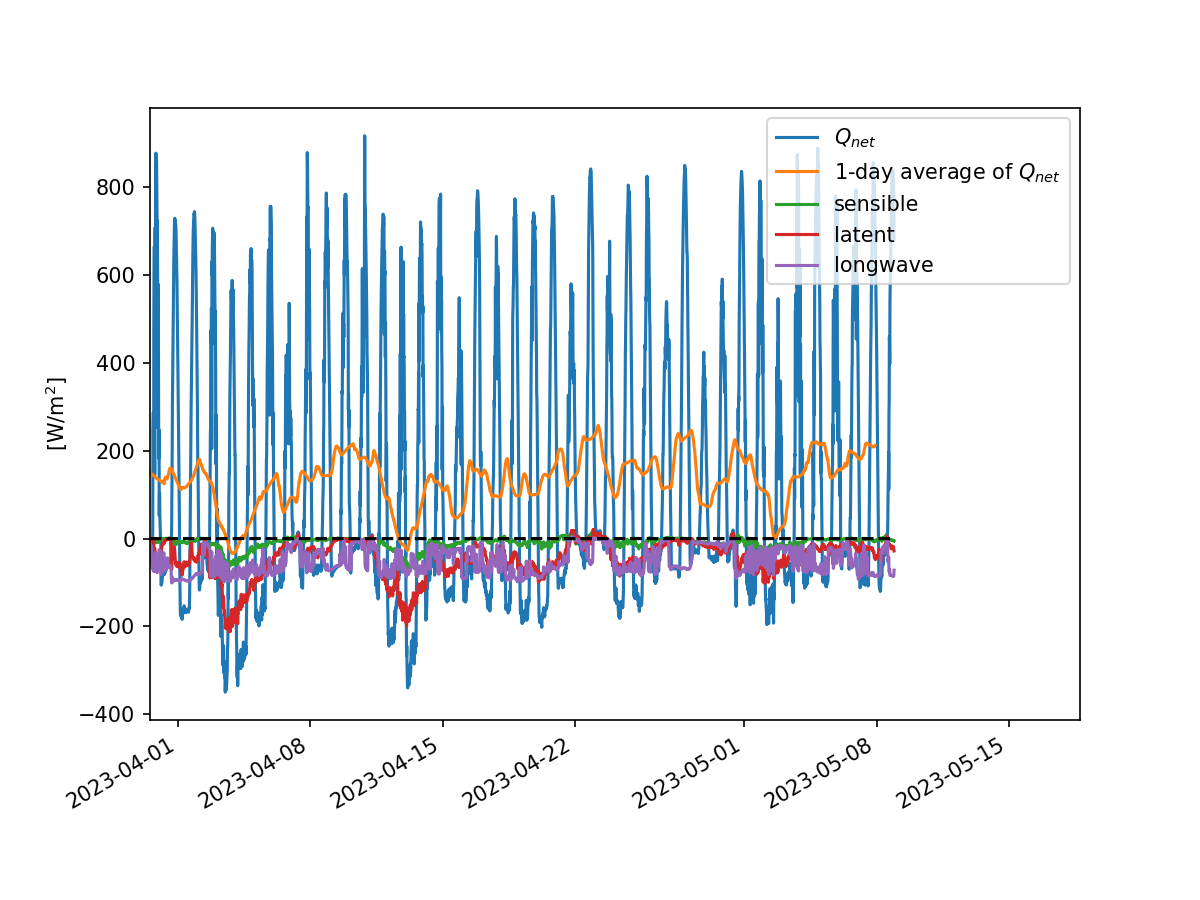

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8, 6),sharex=True)
ax.plot(ds.time,Qnet)
QN_low = functions.run_avg1d(Qnet, 4*24)
ax.plot(ds.time,QN_low)

ax.set(ylabel='[W/m$^2$]')
ax.set_xlim(left=tmin, right=tmax)
ax.plot(ds.time,Qb)     
ax.plot(ds.time,QH)     
ax.plot(ds.time,Ql)     
ax.legend(['$Q_{net}$', '1-day average of $Q_{net}$', 'sensible', 'latent', 'longwave'])
ax.plot(ds.time,0*Qnet,'k--')


'''
ax[1].plot(ds.time,tau)     
ax[1].set(ylabel='tau')
ax[1].set_ylim(bottom=0, top=1)
'''


fig.autofmt_xdate()
ax.set_xlim(left=tmin, right=tmax)
plt.show()


In [18]:
pwd

'/home/jtomf/Python/S-MODE_analysis/code_IOP2'

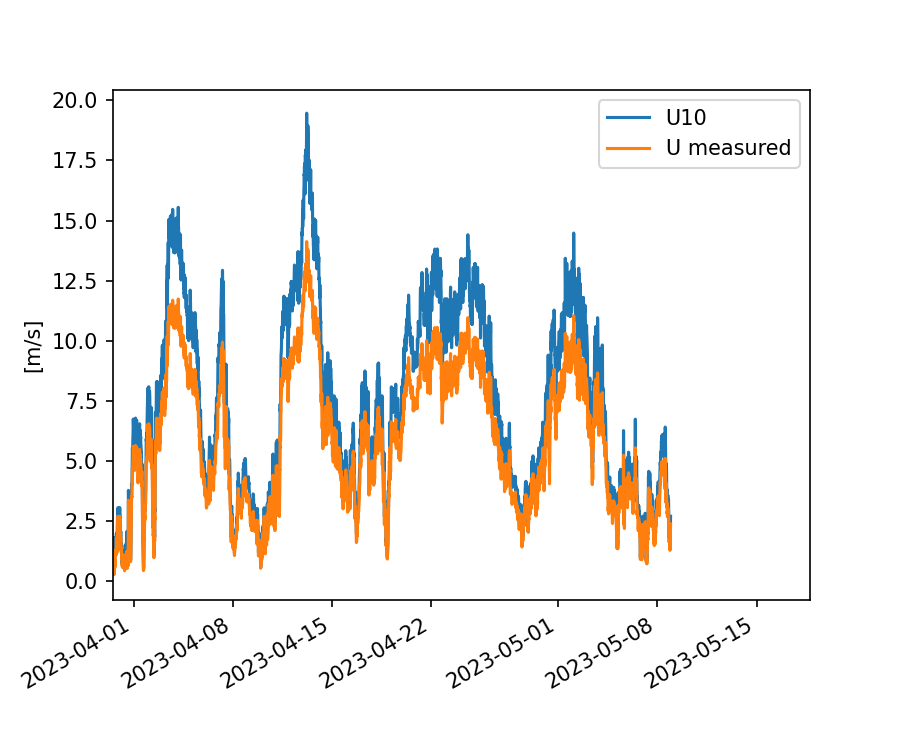

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6, 5),sharex=True)
ax.plot(ds.time,U10)
ax.plot(ds.time,u)

ax.set(ylabel='[m/s]')
ax.set_xlim(left=tmin, right=tmax) 
ax.legend(['U10', 'U measured'])

fig.autofmt_xdate()
ax.set_xlim(left=tmin, right=tmax)
plt.show()

In [20]:
ds

<xarray.Dataset>
Dimensions:                      (time: 4131)
Coordinates:
  * time                         (time) datetime64[ns] 2023-03-23T00:01:00 .....
Data variables: (12/46)
    cr6_card_status              (time) object ...
    batt_volt_Min                (time) float64 ...
    panel_temp_Avg               (time) float64 ...
    proc_time_Max                (time) float64 ...
    proc_time_Avg                (time) float64 ...
    slow_proc_time_1_Max         (time) float64 ...
    ...                           ...
    SGR4_flux_Wm2_Avg            (time) float64 350.8 336.1 ... 303.4 310.9
    index_1hz_file               (time) float64 ...
    index_10hz_file              (time) float64 ...
    index_ADCP_file              (time) float64 ...
    uctd_psu_Avg                 (time) float64 0.004334 0.004352 ... 33.05
    uctd_sigma0_Avg              (time) float64 -0.9844 -0.964 ... 24.66 24.67
Attributes:
    title:                S-MODE IOP2 2023 wave glider
    summary:              real-time wave glider data recorded by SV3 during S...
    time_coverage_start:  2023-03-23T00:16:00Z
    time_coverage_end:    2023-05-08T22:16:00Z